# Machine Learning Meets Quantum: Getting Started with TensorFlow Quantum

Author: [Ping Zhou](http://github.com/zhoupingjay/quantum)

## Introduction

Earlier this year, Google announced [TensorFlow Quantum](https://www.tensorflow.org/quantum). It's a framework for building **Hybrid Quantum-Classical Machine Learning models**. So now we are entering the era of **Quantum Machine Learning** - sounds exciting!

<img src="https://github.com/tensorflow/quantum/blob/master/docs/images/logo/tf_quantum_circle.jpg?raw=true" width=600 />

You may wonder how these two very different worlds work together, and what these hybrid ML models look like.
In this notebook, I'm going to walk you through the ["Hello, many world"](https://www.tensorflow.org/quantum/tutorials/hello_many_worlds) example to explain the basic ideas of building quantum-classical hybrid ML model and how it works on a real problem.

## Concepts

Before we start with the code, I'm going to explain some basic concepts that are needed for understanding this example. Don't be scared by the math notations in this section - they are not as hard as they might appear!

Please be noted that this notebook does not serve as a tutorial of quantum computing - if you need more comprehensive information, please refer to a textbook.

### Qubit, State Vector and Bloch Sphere

Qubit: You might have already heard about the term "qubit". Comparing to a classical bit that can be at either of the two states (e.g. 0 or 1) at any time, a qubit can be at a "superposition" of both states. The state of a qubit $|\psi\rangle$ can be expressed as:

$$
|\psi\rangle = \alpha|0\rangle + \beta|1\rangle
$$

Where $\alpha$ and $\beta$ are complex numbers that tell us the **probabilities** of measurement outcomes: If we measure the qubit, we have $|\alpha|^2$ probability of getting $|0\rangle$, and $|\beta|^2$ probability of getting $|1\rangle$ (and apparently we have $|\alpha|^2+|\beta|^2=1$).

So a qubit can be represented as a **vector** with two complex numbers:
$
\begin{pmatrix}
\alpha \\
\beta
\end{pmatrix}
$

Now we know how to describe a qubit. What about a quantum system? For a system with one or more qubits, we use **state vector** to describe the system's current state. The state vector of the system is the **tensor product** of all qubits in it. For example, if we have a system with two qubits
$\begin{pmatrix}\alpha_1 \\ \beta_1\end{pmatrix}$ and $\begin{pmatrix}\alpha_2 \\ \beta_2\end{pmatrix}$, its state vector is their tensor product:
$$
\begin{pmatrix}\alpha_1 \\ \beta_1\end{pmatrix}
\otimes
\begin{pmatrix}\alpha_2 \\ \beta_2\end{pmatrix} =
\begin{pmatrix}
\alpha_1\alpha_2 \\
\alpha_1\beta_2 \\
\beta_1\alpha_2 \\
\beta_1\beta_2
\end{pmatrix}
$$

If you have used [Cirq](https://github.com/quantumlib/Cirq) (Google's Quantum framework), you'll notice a ``final_state`` member in simulation results -- That's the state vector of the system. You may refer to [this notebook](https://github.com/zhoupingjay/quantum/blob/main/Quantum-Teleportation.ipynb) for an example usage of state vectors.

Another useful way of representing qubit is using the **Bloch Sphere**. Every qubit can be represented as a vector on the surface of the Bloch Sphere.

<img src="./images/bloch-sphere.svg" width=360 />
<div style="text-align: center">Bloch Sphere representation of qubit.</div>

<!---
A qubit $|\psi\rangle$ on Bloch sphere can also be written as:

$$
|\psi\rangle = 
\begin{pmatrix}
\cos{\frac{\theta}{2}} \\
e^{i\phi}\sin\frac{\theta}{2}
\end{pmatrix}
$$
-->

### Operators and Observables

**Operators**

What are "operators"? In short, an operator tranform qubit(s) from one state to another. Since qubits can be written as vectors, the operators are essentially matrices.

**Observables**

Suppose we have a quantum system. How do we know about its state? The only way is through measurements.
Physical quantities that can be measured are called [Observables](https://en.wikipedia.org/wiki/Observable).
For example, position and momentum are observables.

In quantum world, every observable correspond to a [Hermitian Operator](https://en.wikipedia.org/w/index.php?title=Hermitian_operator&redirect=no) - they are a set of operators with special properties (e.g. they equal to their conjugate transpose). In this example, we'll use **Z operator** as the observable. The matrix of Z operator is like this:

$$
Z=
\begin{bmatrix}
1 & 0 \\
0 & -1
\end{bmatrix}
$$

If you apply Z operator on a qubit $\begin{pmatrix}\alpha \\ \beta\end{pmatrix}$, you'll get this $\begin{pmatrix}\alpha \\ -\beta\end{pmatrix}$.

### Expectation Values

Being able to get state vectors of your system is nice - it means you know everything of your system.
Unfortunately this is only available in simulator.
In real world, it's usually impossible to get the state vector of your system.
Instead, what you'll get is the **expectation value** of your system.

Expectation value is actually a concept from probability theory.
Imagine you are throwing a dice which gives you a number between 1 and 6 each time.
The expectation value of your dice is the **sum of all possible outcomes weighted by their probabilities**.
Assuming your dice is perfect (i.e. each of the 6 outcomes has equal probability),
the expectation value of your dice is:
$$
\frac{1}{6}\times 1 + \frac{1}{6}\times 2 + ... + \frac{1}{6}\times 6 = 3.5
$$

When we talk about an expectation value in quantum world, we need to specify both the **state** and the **operator (observable)**.

For example, we won't say
>"Expecation value of this state vector is 0.5"

Instead, we'll say
>"Expectation value of this state vector **on Z operator** is 0.5"*.

Why? Because different observables will give different expectation values.
As an analogy, think about projecting a vector onto an axis - choosing a different axis will give you different projection value.

---
So what exactly is the **expectation value of a state vector on Z operator**? To save your time, I'll just write down the answer here:

* Expectation value of a state vector on Z observable is $\cos\theta$, which is its projection on Z axis.

If you are interested, you are welcome to work out the mathematics. It's actually pretty straightforward. :-)

We can look at a few examples to validate this conclusion:

<img src="./images/bloch-sphere.svg" width=360 />

- If current state is at "north pole" of the Bloch Sphere, we get 100% chance of getting +Z from measurements. Expectation value is $\cos 0 = 1$.
- If current state is at "south pole" of the Bloch Sphere, we get 100% chance of getting -Z from measurements. Expectation value is $\cos\pi = -1$.
- If current state is at point D on Bloch Sphere, we get 50% chance of getting +Z and 50% chance of -Z from measurements. Expectation value is $\cos\frac{\pi}{2}=0$.

Things match up. Fantastic!

## What Are We Trying to Solve?

To understand the hybrid model we are going to build, we need to first understand the problem we are trying to solve.

Imagine we have a quantum circuit to run. The first thing we need to do is to prepare the initial qubits for the circuit (typically $|0\rangle$ or $|1\rangle$).

In simulations, we assume perfect qubits to be fed into our circuit.
But in the real world, our system is **noisy**. Therefore the qubits we prepare are not perfect - they could deviate from the states we want. If you consider this on Bloch Sphere, it is as if a "perfect" qubit has been rotated in X/Y/Z directions with unknown angles, making it imperfect. This can be emulated as putting Rotation gates on the perfect qubit.

<img src="./images/tfq-noisy-circuit.svg" alt="Noisy circuit" width=360 />

The angles $\beta_1$, $\beta_2$, $\beta_3$ caused by noise are unknown to us.

In order for any quantum computing circuit to run properly, we need to **calibrate** our qubit to the target state we want. How do we do that? We simply rotate the qubit on X/Y/Z directions again to compensate for the noises. So basically we'll apply Rotation gates to the noisy qubit:

<img src="./images/tfq-calibration-circuit.svg" alt="Noisy circuit" width=360 />

**Our problem** is to determine the three parameters ($\theta_1$, $\theta_2$, $\theta_3$) for our calibration circuit. We'll build a quantum-classical hybrid machine learning model to solve this problem.

## Quantum-Classical Hybrid Machine Learning Model

The original notebook has lot of details and may not be very straightforward. I find it a better way to look from a high level first.

What we want to achieve is a model that calibrates noisy qubit:

<img src="./images/hello-tfq-circuit.svg" width=560 />

Since we are building a Machine Learning model, we need to answer these important questions:
- What are the inputs (datasets)?
- What are the labels?
- What are the outputs?

To help you understand the whole picture, I made an architectural diagram of our hybrid Quantum-Classical ML model. I'll explain the components in the following sections.

<img src="./images/hello-tfq-1.svg" width=520 />
<div style="text-align: center">Overall architecture of our hybrid Quantum-Classical ML model.</div>
<div style="text-align: center">A simple DNN is used for the classical part, as the problem is fairly small.</div>

### Datasets
Our dataset includes two parts: commands and the noisy circuit.

**Commands**

"Commands" correpond to the target states we want our qubits to achieve.
In this example, command 0 means we want the circuit to prepare a qubit at the "south pole" ($|0\rangle$), and command 1 means "north pole" ($|1\rangle$).

**Noisy input**

This is the circuit that emulates the noisy qubit that needs to be calibrated. TensorFlow Quantum (TFQ) provides a function ``tfq.convert_to_tensor`` to convert circuit objects from Cirq into tensors:

```python
circuit_tensor = tfq.convert_to_tensor([circuit])
```

### Labels

The labels are the **expecation values of the target states** we want our qubits to achieve.
In this example, we want the qubit to be at $|0\rangle$ (for input command 0) or $|1\rangle$ (for input command 1). As we have seen earlier, expectation values at $|0\rangle$ and $|1\rangle$ are 1 and -1 respectively. Therefore our labels correspond to input commands are ``[1, -1]``.

### Outputs

The outputs of our hybrid model are the expecation values of the calibrated qubits.

### Model

Our model will include both classical and quantum parts.
* The **classical part** is the "controller" in the diagram. It's a normal DNN, nothing special. Its outputs are the parameters ($\theta_1$, $\theta_2$, $\theta_3$) for calibration circuit.
* The **quantum part** is the "ControllPQC" layer (we'll name it "expection_layer"). It takes the parameters ($\theta_1$, $\theta_2$, $\theta_3$) from controller, uses them to run the calibration circuit ("model_circuit"), and feeds back the outputs (expectation values) to the controller for training.

---
So in summary, this is what we tell our model to do:

> Here is a nosiy qubit (circuit_input) and two commands (0, 1). We want you to spit out the qubit with expectation value of 1 on command 0 and expection value of -1 on command 1.

Does it make more sense now? :-)

## Code Walkthrough

Now we have a decent understanding of the problem and our model. Let's get to the code.

### Setup

You'll need to install TensorFlow (2.3.1+) and TensorFlow Quantum on your computer. The easiest way is to use pip:

```python
pip install -q tensorflow==2.3.1
pip install -q tensorflow-quantum
```

### Import modules

Import TFQ and the dependency modules:

In [1]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

### Prepare the Inputs

First we'll create a qubit and prepare the dataset.

In [2]:
# This creates a "perfect" qubit at |0>.
# It will be fed into the noisy preparation circuit to emulate a noisy qubit.
qubit = cirq.GridQubit(0, 0)

In [3]:
# Dataset: commands_input (0 and 1)
commands = np.array([[0], [1]], dtype=np.float32)

Create a noisy circuit with randomly generated angles, and convert it into tensor so it can be used by TensorFlow.

Note that we'll need two copies of the circuit because we have two entries in the dataset (command 0 and command 1).

In [4]:
# Dataset: circuit_input (noisy preparation)
# This emulates the noisy qubit by applying X/Y/Z rotations with random angles.
random_rotations = np.random.uniform(0, 2 * np.pi, 3)
noisy_preparation = cirq.Circuit(
  cirq.rx(random_rotations[0])(qubit),
  cirq.ry(random_rotations[1])(qubit),
  cirq.rz(random_rotations[2])(qubit)
)

# Convert the circuit object to tensor.
# Two copies of the circuit because we have two commands (0 and 1) to train.
datapoint_circuits = tfq.convert_to_tensor([
  noisy_preparation
] * 2)

Print out the noisy circuit. We can see that the "perfect" qubit has been rotated on X, Y and Z axis with some random angles.

In [5]:
# Print out the noisy qubit
print(random_rotations)
print(noisy_preparation)

[3.84902356 3.3647054  3.03737137]
(0, 0): ───Rx(1.23π)───Ry(1.07π)───Rz(0.967π)───


We'll then create the Keras input from the datasets.
These will be used when we call tf.keras.Model() later.

In [6]:
# Create keras inputs from the datasets
circuits_input = tf.keras.Input(shape=(),
                                # The circuit-tensor has dtype `tf.string` 
                                dtype=tf.string,
                                name='circuits_input')
commands_input = tf.keras.Input(shape=(1,),
                                dtype=tf.dtypes.float32,
                                name='commands_input')

### Prepare the Labels

The labels are the expectation values we want for each command. In this example, we want 1 for command 0 and -1 for command 1.

In [7]:
# Labels: target expecation values (1 for command 0, -1 for command 1)
expected_outputs = np.array([[1], [-1]], dtype=np.float32)

### Build our model

Classical part of the model is a simple DNN. Since the problem is fairly small, a simple DNN with two layers will be good enough.

In [8]:
# Classical part of our model - "controller".
# Since the problem is fairly small, a simple DNN is enough.
controller = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation='elu'),
    tf.keras.layers.Dense(3)
])

Then the quantum part of our label. We first use the Cirq API to build our calibration circuit (``model_circuit``) with three parameters ($\theta_1$, $\theta_2$, $\theta_3$).

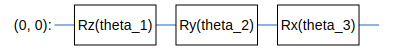

In [9]:
# Quantum part of our model - "model_circuit"
# Parameters that the classical NN will feed values into.
control_params = sympy.symbols('theta_1 theta_2 theta_3')

# Create the parameterized circuit.
qubit = cirq.GridQubit(0, 0)
model_circuit = cirq.Circuit(
    cirq.rz(control_params[0])(qubit),
    cirq.ry(control_params[1])(qubit),
    cirq.rx(control_params[2])(qubit))

SVGCircuit(model_circuit)

How do we incorporate this calibration circuit (``model_circuit``) into our model? We need to wrap it into a Keras layer so it can be connected with other layers.

In this example we'll wrap our circuit with the "Parameterized Quantum Circuit" (PQC) layer: ``tfq.layers.ControlledPQC``. We name it ``expectation_layer`` because it outputs the expection values.

Also note the argument ``operators`` when we create the layer: Remember that we need to specify operator when we talk about expectation value. This is how we tell PQC that we'll take expectation values on Z operator.

After ``expectation_layer`` is created, we then connect it with the noisy circuit (``circuits_input``) and calibration parameters (outputs from controller, which is ``dense_2``).

In [10]:
dense_2 = controller(commands_input)

# TFQ layer for classically controlled circuits.
expectation_layer = tfq.layers.ControlledPQC(model_circuit,
                                             # Observe Z
                                             operators = cirq.Z(qubit))
expectation = expectation_layer([circuits_input, dense_2])

We then build the model in Keras just as usual.

In [11]:
model = tf.keras.Model(inputs=[circuits_input, commands_input],
                       outputs=expectation)

A little visualization of our model...

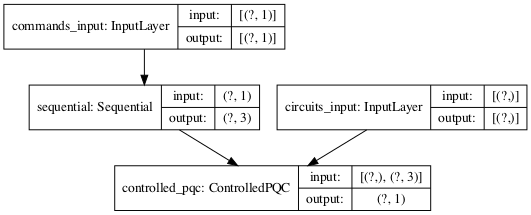

In [12]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=70)

### Train our model

We then train our model just like a normal DNN, using Adam as optimizer and MSE as the loss function.

In [13]:
# Now we can train the model...
optimizer = tf.keras.optimizers.Adam(learning_rate=0.05)
loss = tf.keras.losses.MeanSquaredError()
model.compile(optimizer=optimizer, loss=loss)
history = model.fit(x=[datapoint_circuits, commands],
                    y=expected_outputs,
                    epochs=30,
                    verbose=0)

Training history shows that we are doing good...

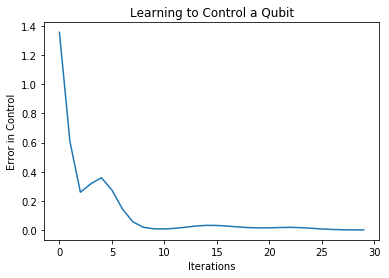

In [14]:
# Plot the history - looks good!
plt.plot(history.history['loss'])
plt.title("Learning to Control a Qubit")
plt.xlabel("Iterations")
plt.ylabel("Error in Control")
plt.show()

### Verify our model

We can verify our model by calling it with commands 0 and 1:

In [15]:
model([datapoint_circuits, commands])

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[ 0.9891974],
       [-0.9958328]], dtype=float32)>

As we can see, our model has calibrated the qubit into pretty well:
- On command 0, it gave expectation value of 0.98114353
- On command 1, it gave expectation value of -0.9409604

Both are very close to the target (1 and -1).

Congratulations! You have successfully trained your first Hybrid Quantum-Classical Machine Learning Model!

## Next Steps

In the next step, I'll expand this example into a more generic case where we can calibrate qubit with expectation values on other operators.